In [157]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [151]:
import numpy as np
from kmodes import kprototypes
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from datetime import date
from abc import abstractmethod
import os


def set_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))


def set_sex(sex_str):
    if sex_str == 'female':
        return 0
    elif sex_str == 'male':
        return 1


def next_month(year, month):
    if month == 12:
        return year+1, 1
    else:
        return year, month+1

    
def visualize_bmi_steps(df_bmi_steps, n_months):
    x_ticks = [m for m in range(1,n_months+1)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(x_ticks, df_bmi_steps['bmi'], 'b-')
    ax1.set_xlabel('month')

    ax1.set_ylabel('bmi', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(x_ticks, df_bmi_steps['steps'], 'g-')
    ax2.set_ylabel('steps', color='g')
    ax2.tick_params('y', colors='g')

    fig.tight_layout()
    plt.show()

class UsersClusters:

    def __init__(self, num_clusters, data_dir='.'):
        with open(os.path.join(data_dir, 'bmi_steps.pickle'), 'rb') as f:
            self.bmi_steps = pd.DataFrame(pickle.load(f))
        with open(os.path.join(data_dir,'users_filter.pickle'), 'rb') as f:
            self.users = pd.DataFrame(pickle.load(f))

            self.users['age'] = self.users['birthday'].apply(lambda x: set_age(x))
            self.users['sex'] = self.users['sex'].apply(lambda x: set_sex(x))

            self.users_data = pd.merge(self.users, self.user_entries_per_month(), on='user_id')
            
            self.rescale_info = {
                'age': {
                    'min': min(self.users_data['age']),
                    'range': max(self.users_data['age']) - min(self.users_data['age'])
                },
                'bmi': {
                    'min': min(self.users_data['bmi']),
                    'range': max(self.users_data['bmi']) - min(self.users_data['bmi'])
                },
            }
            
            
            self.cluster_data = np.array(self.users_data[['sex', 'age', 'bmi']])
            self.cluster_data[:,1] = self.rescale_data(self.cluster_data[:,1], 'age' )
            self.cluster_data[:,2] = self.rescale_data(self.cluster_data[:,2], 'bmi' )
   
            self.clusters = self.find_clusters(num_clusters)

    @abstractmethod
    def find_clusters(self, num_clusters):
        return NotImplemented

    @abstractmethod
    def get_cluster(self, sex, age, bmi):
        return NotImplemented
    
    def rescale_data(self, data_value, data_type):
        return (data_value - self.rescale_info[data_type]['min']) / self.rescale_info[data_type]['range']
    
    def user_entries_per_month(self):
        bmi_steps_month = self.bmi_steps.groupby(
            ['user_id', 'year', 'month'])['bmi', 'steps'].agg('mean')
        return bmi_steps_month.reset_index()

    def get_cluster_members(self, cluster_label):
        idx = [i for i, x in enumerate(self.clusters.labels_) if x == cluster_label]
        return self.users_data.iloc[idx]

    def recommender_user_sequence(self, sex, age, bmi, n_months):
        cluster_label = self.get_cluster(sex, age, bmi)
        cluster_members = self.get_cluster_members(cluster_label)
        return best_cluster_sequence(cluster_members, n_months)


class KMeansUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = KMeans(n_clusters=num_clusters)
        return clusters.fit(self.cluster_data)

    def get_cluster(self, sex, age, bmi):
        return self.clusters.predict(np.array(
            [[sex, self.rescale_data(age, 'age'), self.rescale_data(bmi, 'bmi')]]))[0]


class KPrototypeUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = kprototypes.KPrototypes(n_clusters=num_clusters, init='Cao')
        return clusters.fit(self.cluster_data, categorical=[0])

    def get_cluster(self, sex, age, bmi):
        return self.clusters.predict(np.array(
            [[sex, self.rescale_data(age, 'age'), self.rescale_data(bmi, 'bmi')]]), 
                                     categorical=[0])[0]


def is_ordered_sequence(seq):
    for i in range(len(seq) - 1):
        if (seq[i + 1]['year'], seq[i + 1]['month']) != next_month(
                seq[i]['year'], seq[i]['month']):
            return False
    return True


def get_user_sequences(user_entries, n_months):
    user_entries.sort_values(['year', 'month'])
    user_sequences = []
    for i in range(len(user_entries)-n_months):
        seq = []
        for j in range(n_months):
            seq.append(user_entries.iloc[i+j])
        if is_ordered_sequence(seq):
            user_sequences.append(seq)
    return user_sequences


def best_user_sequence(user_entries, n_months):
    user_sequences = get_user_sequences(user_entries, n_months)
    first = True
    best_seq = None
    best_corr = None
    for seq in user_sequences:
        df = pd.DataFrame(seq)
        if df.bmi.std() < 0.01:
            continue
        cur_corr = df[['bmi','steps']].corr()['bmi']['steps']
        if first:
            first=False
            best_seq = seq
            best_corr = cur_corr
        elif cur_corr < best_corr:
            best_seq = seq
            best_corr = cur_corr
    return best_seq, best_corr


def best_cluster_sequence(cluster_members, n_months):
    best_cluster_seq = None
    best_cluster_corr = None
    first = True
    for user_id in set(cluster_members.user_id):
        user_entries = cluster_members[cluster_members.user_id == user_id]
        best_seq, best_corr = best_user_sequence(user_entries, n_months)
        if best_corr is None:
            continue
        if first:
            first = False
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
        elif best_corr < best_cluster_corr:
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
    return best_cluster_seq, best_cluster_corr


if __name__ == "__main__":
    # Create Clusters
    number_of_clusters = 10
    users_clusters = KMeansUsersClusters(number_of_clusters, data_dir='../data/filtered')

# Visualize clusters

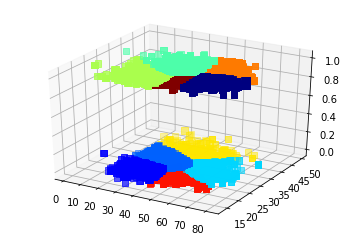

In [152]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

age = []
sex = []
bmi = []
cluster = []
for i in range(number_of_clusters):
    members = users_clusters.get_cluster_members(i)
    age.extend(members.age)
    sex.extend(members.sex)
    bmi.extend(members.bmi)
    cluster.extend([i] * len(members))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(age,bmi,sex, marker="s", c=cluster, s=40, cmap="jet_r")
# ax.scatter(age,bmi,sex, marker="s", c=cluster, s=40)
plt.show()


# Visualize Graphs for each cluster

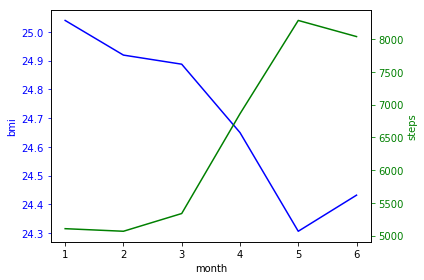

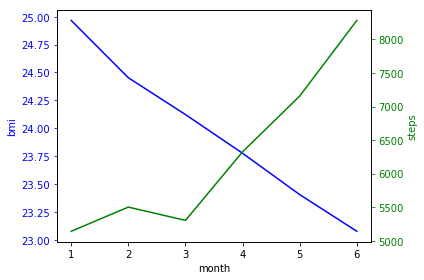

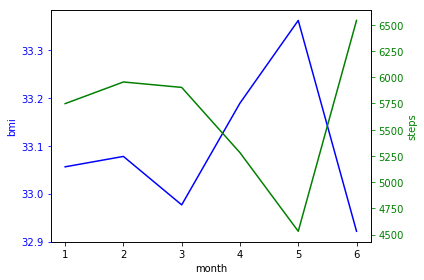

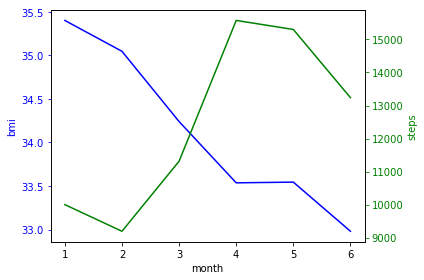

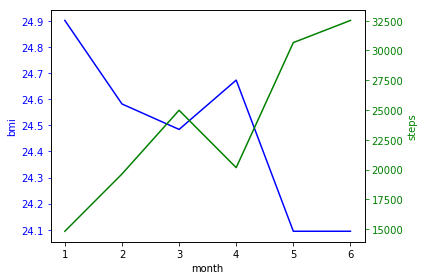

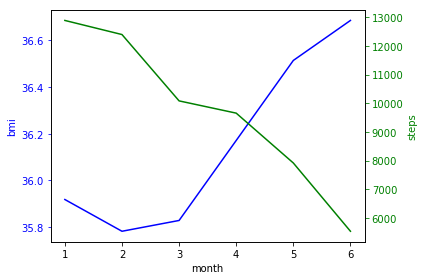

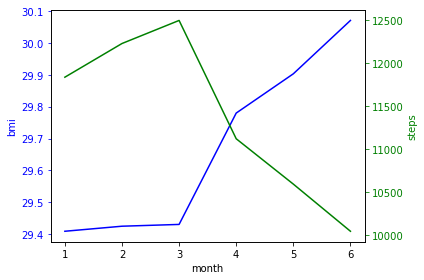

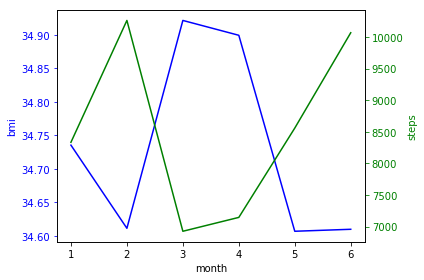

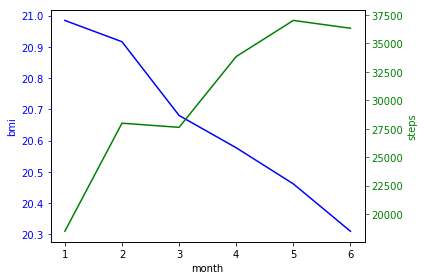

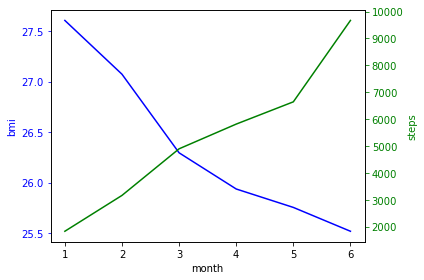

In [154]:
n_months = 6
for i in range(number_of_clusters):
    cluster_members = users_clusters.get_cluster_members(i)
    best_seq, corr = best_cluster_sequence(cluster_members, n_months)

    visualize_bmi_steps(pd.DataFrame(best_seq)[['bmi','steps']], n_months)
    


# Test on user data

User data (sex,age,bmi): 0 44 25.9424067359
Cluster data (sex,age,bmi): 0 52 24.9665486029


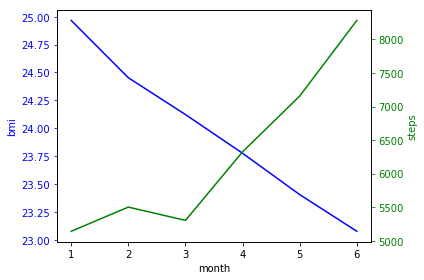

In [155]:
user_id = '2a786a87-f00b-461a-90cd-c1a7a9a06f2e'
year = 2016
month = 2
n_months = 6

user_data = users_clusters.users_data[
    (users_clusters.users_data.user_id == user_id) &
    (users_clusters.users_data.year == year) &
    (users_clusters.users_data.month == month)]

sex = user_data['sex'].values[0]
age = user_data['age'].values[0]
bmi = user_data['bmi'].values[0]
print('User data (sex,age,bmi):', sex,age,bmi)

recommended_seq, corr = users_clusters.recommender_user_sequence(sex, age, bmi, n_months)
print('Cluster data (sex,age,bmi):', 
      recommended_seq[0]['sex'], recommended_seq[0]['age'], recommended_seq[0]['bmi'])

visualize_bmi_steps(pd.DataFrame(recommended_seq)[['bmi','steps']], n_months)

# Test on given input data

Input data (sex,age,bmi): 1 37 28
Cluster data (sex,age,bmi): 1 39 24.9016884617


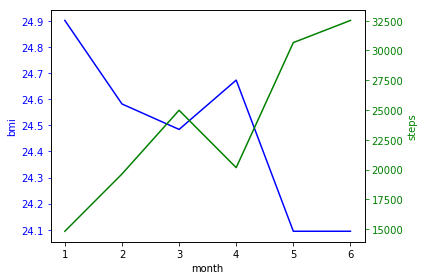

In [156]:
sex = 1
age = 37
bmi = 28
print('Input data (sex,age,bmi):', sex,age,bmi)

recommended_seq, corr = users_clusters.recommender_user_sequence(sex, age, bmi, n_months)
print('Cluster data (sex,age,bmi):', 
      recommended_seq[0]['sex'], recommended_seq[0]['age'], recommended_seq[0]['bmi'])

visualize_bmi_steps(pd.DataFrame(recommended_seq)[['bmi','steps']], n_months)